In [12]:
import os
import json

# Folder paths
compare_util_folder = r'F:/setup files/downloads/CompareUtil'
result2_folder = r'F:/setup files/downloads/ResultLast'
output_folder = r'F:/setup files/downloads/ResultLastly'

# Keys to keep
keys_compare = ["Original", "Proposed", "PFG-EMOA"]
keys_result2 = ["NSGA-II", "MOEA/D", "MOEA/D+"]

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get the set of files in each folder
compare_files = set(os.listdir(compare_util_folder))
result2_files = set(os.listdir(result2_folder))

# Find files that exist in both folders (same filename)
common_files = compare_files & result2_files

# Merge data from matching files
for filename in common_files:
    compare_path = os.path.join(compare_util_folder, filename)
    result2_path = os.path.join(result2_folder, filename)
    
    # Only proceed if they are JSON files 
    # (e.g., check extension if needed)
    if not filename.lower().endswith('.json'):
        continue
    
    # Load data from CompareUtil
    with open(compare_path, 'r', encoding='utf-8') as f:
        data_compare = json.load(f)
    
    # Load data from Result2
    with open(result2_path, 'r', encoding='utf-8') as f:
        data_result2 = json.load(f)
    
    # Prepare new merged dictionary
    merged_data = {}
    
    # Extract the desired keys from CompareUtil data
    for key in keys_compare:
        if key in data_compare:
            merged_data[key] = data_compare[key]
    
    # Extract the desired keys from Result2 data
    for key in keys_result2:
        if key in data_result2:
            merged_data[key] = data_result2[key]
    
    # Save the merged JSON in ResultFinal folder
    output_path = os.path.join(output_folder, filename)
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(merged_data, f, indent=4, ensure_ascii=False)

    print(f"Merged file saved: {output_path}")

Merged file saved: F:/setup files/downloads/ResultLastly\LRC2_2_4_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LR2_4_5_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LR2_8_7_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LRC1_8_10_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LC1_2_10_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LR2_8_10_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LR1_8_9_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LC1_2_8_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LRC2_2_7_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LC2_2_8_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LRC1_2_7_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LRC1_2_6_0.json
Merged file saved: F:/setup files/downloads/ResultLastly\LC1_4_3_0.json
Merged file saved: F:/setup files/downloads/ResultLastly

In [13]:
import os
import json
import csv
from glob import glob

# Define the directory and file pattern
# path = "F:/setup files/downloads/Result2/"
path = "F:/setup files/downloads/ResultLastly/"
file_pattern = os.path.join(path, "*.json")

# List of files matching our pattern
files = glob(file_pattern)

# Prepare a list to store results
results = []

# Loop through each JSON file
for filename in files:
    # Load JSON data
    with open(filename, 'r') as f:
        data = json.load(f)

    # Determine number of objectives using the first algorithm/generation/solution
    # (Assuming at least one algorithm, one generation, and one individual exist)
    sample_alg = next(iter(data))
    sample_gen = next(iter(data[sample_alg]))
    sample_solution = data[sample_alg][sample_gen][0]
    objectives_count = len(sample_solution)

    # Initialize nadir point with very small values
    nadir = [-float('inf')] * objectives_count

    # Iterate over all algorithms, generations, and individuals to compute nadir
    for algorithm in data:
        for generation in range(1,100):
            # print(algorithm, generation)
            for individual in data[algorithm][str(generation)]:
                # Update nadir for each objective dimension
                for idx, value in enumerate(individual):
                    if value > nadir[idx]:
                        nadir[idx] = value

    # Store filename (or parsed info) and computed nadir point
    base_filename = os.path.basename(filename)
    result_row = {"file": base_filename}
    # Add each objective's nadir value to the row
    for j in range(objectives_count):
        result_row[f"obj_{j+1}_nadir"] = nadir[j]

    results.append(result_row)

# Define CSV fieldnames based on objectives count
fieldnames = ["file"] + [f"obj_{j+1}_nadir" for j in range(objectives_count)]

# Write results to a CSV file
output_csv = os.path.join(path, "nadir_points.csv")
with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(results)

print(f"Nadir points saved to {output_csv}")

Nadir points saved to F:/setup files/downloads/ResultLastly/nadir_points.csv


In [14]:
import os
import json
import pandas as pd
from pymoo.indicators.hv import HV
import numpy as np

def cal_hv(front, ref_point):
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_front = np.divide(front, ref_point, out=np.zeros_like(front), where=ref_point!=0)
    scaled_ref_point = np.ones_like(ref_point)
    hv_indicator = HV(ref_point=scaled_ref_point)
    return hv_indicator(scaled_front)

# Paths and file info
# path = "F:/setup files/downloads/Result2/"
nadir_csv_path = os.path.join(path, "nadir_points.csv")
hv_csv_path = os.path.join(path, "hv_values.csv")
pivot_csv_path = os.path.join(path, "hv_pivot.csv")  # For pivoted result

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)
print("Nadir Points DataFrame:")
print(nadir_df.head())

hv_results = []

# Iterate over each row (each file) in the nadir DataFrame
for index, row in nadir_df.iterrows():
    file_name = row['file']
    file_path = os.path.join(path, file_name)

    # Check if JSON file exists
    if not os.path.isfile(file_path):
        print(f"File {file_name} not found. Skipping.")
        continue

    # Load JSON data
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Extract the nadir point for scaling
    obj_columns = sorted(
        [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
        key=lambda x: int(x.split('_')[1])
    )
    nadir_point = np.array([row[col] for col in obj_columns])

    # For each algorithm in the JSON data

    last = "100"
    for algorithm in data:
        if last not in data[algorithm]:
            print(f"Generation {last} not found for algorithm {algorithm} in file {file_name}. Skipping.")
            continue

        solutions = data[algorithm][last]
        solutions_np = np.array(solutions)

        if solutions_np.size == 0:
            print(f"No solutions found for algorithm {algorithm} in generation {last} of file {file_name}. Skipping.")
            continue

        try:
            hv_value = cal_hv(solutions_np, nadir_point)
        except Exception as e:
            print(f"Error computing HV for algorithm {algorithm} in file {file_name}: {e}")
            continue

        hv_results.append({
            "file": file_name,
            "algorithm": algorithm,
            "HV": hv_value
        })

# Convert HV results to a DataFrame
hv_df = pd.DataFrame(hv_results)

# Pivot the DataFrame: rows as file names, columns as algorithms, values as HV
hv_pivot_df = hv_df.pivot(index='file', columns='algorithm', values='HV')

# Save the pivoted HV DataFrame to a CSV file
hv_pivot_df.to_csv(pivot_csv_path)

print(f"Pivoted hypervolume table saved to {pivot_csv_path}")


Nadir Points DataFrame:
              file  obj_1_nadir  obj_2_nadir  obj_3_nadir  obj_4_nadir
0  LC1_2_10_0.json  1889.260877   191.618082  1921.153037  3868.706603
1   LC1_2_1_0.json  2004.677867   216.106415  3013.231277  5530.458606
2   LC1_2_2_0.json  1917.356225   186.458585  2646.831075  4881.059242
3   LC1_2_3_0.json  1797.444220   237.331890  2851.857745  5702.705454
4   LC1_2_4_0.json  1623.497047   136.508705  1849.709111  3399.629740
Pivoted hypervolume table saved to F:/setup files/downloads/ResultLastly/hv_pivot.csv


In [15]:
import os
import json
import glob
import pandas as pd
import numpy as np
from pymoo.indicators.hv import HV

def cal_hv(front, ref_point):
    with np.errstate(divide='ignore', invalid='ignore'):
        scaled_front = np.divide(front, ref_point, out=np.zeros_like(front), where=ref_point!=0)
    scaled_ref_point = np.ones_like(ref_point)
    hv_indicator = HV(ref_point=scaled_ref_point)
    return hv_indicator(scaled_front)

# Settings
base_path = "F:/setup files/downloads/ResultLastly/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")

# Load the nadir points CSV
nadir_df = pd.read_csv(nadir_csv_path)

# Define generation range from 0 to 150
generation_steps = range(0, 101)  # 0 to 150

# Choose problem types or adapt as needed
problem_types = [200, 400, 800]

for prob_type in problem_types:
    # Adjust file pattern as needed based on naming convention
    file_pattern = os.path.join(base_path, f"*_{prob_type//100}_*_0.json")
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found for problem type {prob_type}.")
        continue

    # Dictionary to store HV trends: {algorithm: {generation: [HV values across files]}}
    hv_trends = {}

    for file_path in files:
        file_name = os.path.basename(file_path)

        # Retrieve corresponding nadir row
        nadir_row = nadir_df[nadir_df['file'] == file_name]
        if nadir_row.empty:
            print(f"Nadir info not found for {file_name}. Skipping.")
            continue
        nadir_row = nadir_row.iloc[0]

        # Extract nadir point for scaling
        obj_columns = sorted(
            [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
            key=lambda x: int(x.split('_')[1])
        )
        nadir_point = np.array([nadir_row[col] for col in obj_columns])

        # Load JSON data from file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Iterate over algorithms in the JSON data
        for algorithm in data:
            # Initialize hv_trends for algorithm if not present
            if algorithm not in hv_trends:
                hv_trends[algorithm] = {gen: [] for gen in generation_steps}

            # Loop through generations 0 to 150
            for gen in generation_steps:
                gen_key = str(gen)
                if gen_key not in data[algorithm]:
                    # Skip if generation data is missing
                    continue

                solutions = data[algorithm][gen_key]
                solutions_np = np.array(solutions)

                if solutions_np.size == 0:
                    continue

                try:
                    hv_value = cal_hv(solutions_np, nadir_point)
                except Exception as e:
                    print(f"Error computing HV for {algorithm} at generation {gen} in {file_name}: {e}")
                    continue

                hv_trends[algorithm][gen].append(hv_value)

    # Compute average HV per generation across files for each algorithm
    avg_hv_trends = {}
    for algorithm, gen_dict in hv_trends.items():
        avg_hv_trends[algorithm] = {
            gen: np.mean(hv_list) if hv_list else np.nan 
            for gen, hv_list in gen_dict.items()
        }

    # Convert the average HV trends into a DataFrame and save to CSV
    df_avg_hv = pd.DataFrame(avg_hv_trends)
    csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{prob_type//100}.csv")
    df_avg_hv.to_csv(csv_filename, index_label='Generation')
    print(f"Average HV trends saved to {csv_filename}")

    # If you only want to process the first problem type, uncomment the next line:
    # break

Average HV trends saved to F:/setup files/downloads/ResultLastly/Avg_HV_Trends_Type_2.csv
Average HV trends saved to F:/setup files/downloads/ResultLastly/Avg_HV_Trends_Type_4.csv
Average HV trends saved to F:/setup files/downloads/ResultLastly/Avg_HV_Trends_Type_8.csv


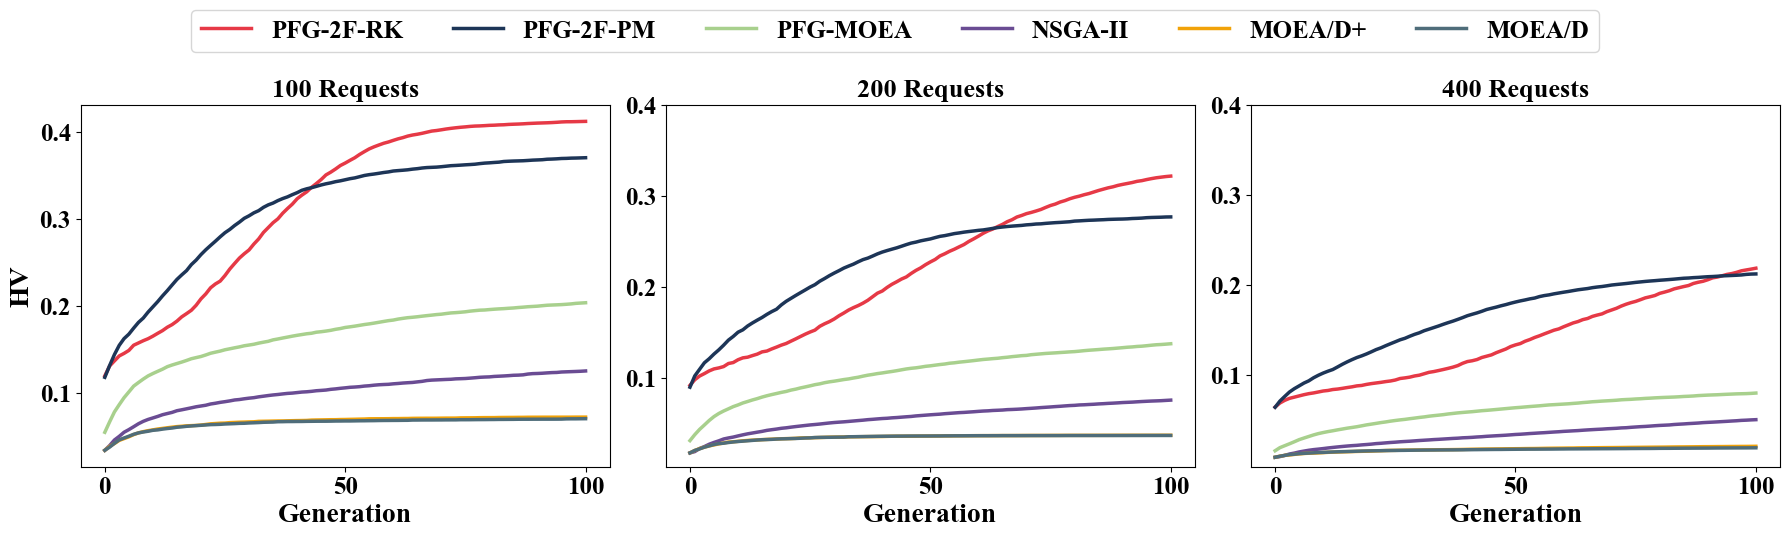

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Settings
base_path = "F:/setup files/downloads/ResultLastly/"  # Ensure base_path is defined
problem_types = [200, 400, 800]

# Define custom colors for each algorithm
algorithm_colors = {
    'PFG-EMOA': '#E63946',
    'Proposed': '#1D3557',
    'Original': '#A8D08D',
    'NSGA-II': '#6A4C93',
    'MOEA/D': '#4F6D7A',
    'MOEA/D+': '#F1A208'
}

# Create a single figure with 3 subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5.2))
plt.subplots_adjust(top=0.85)  # Adjust top margin for titles

# Legend style
legend_font = {"family": "Times New Roman", "size": 18, "weight": "bold"}

# We'll collect legend handles and labels from all subplots
all_handles = []
all_labels = []

for idx, (ax, prob_type) in enumerate(zip(axes, problem_types)):
    csv_filename = os.path.join(base_path, f"Avg_HV_Trends_Type_{prob_type//100}.csv")
    
    # Check if CSV exists
    if not os.path.exists(csv_filename):
        print(f"CSV file {csv_filename} not found. Skipping.")
        continue

    # Read CSV file
    df_avg_igd = pd.read_csv(csv_filename, index_col='Generation')

    # Plot convergence for each algorithm on the current subplot
    for algorithm in ['PFG-EMOA', 'Proposed','Original', 'NSGA-II', 'MOEA/D+', 'MOEA/D']:
        if algorithm not in df_avg_igd.columns:
            continue
        generations = df_avg_igd.index
        values = df_avg_igd[algorithm]
        
        # Rename algorithms for legend display
        if algorithm == 'Proposed':
            plot_label = 'PFG-2F-PM'
        elif algorithm == 'PFG-EMOA':
            plot_label = 'PFG-2F-RK'
        elif algorithm == 'Original':
            plot_label = 'PFG-MOEA'
        else:
            plot_label = algorithm
        
        # Use specified color if available
        color = algorithm_colors.get(algorithm, None)
        
        line, = ax.plot(generations, values, label=plot_label, linewidth=2.5, color=color)
        
        # Collect legend info from the first subplot iteration to avoid duplicates
        if idx == 0 and plot_label not in all_labels:
            all_handles.append(line)
            all_labels.append(plot_label)

    # Set title above each subplot as a subtitle
    ax.set_title(f'{prob_type//2} Requests', fontsize=19, fontweight='bold')

    # X and Y labels; only put y-label on the first subplot
    ax.set_xlabel('Generation', fontsize=20, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('HV', fontsize=20, fontweight='bold')

    # Set X ticks (positions)
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels([0, 50, 100], fontdict={'weight': 'bold', 'size': 18})

    # Set Y ticks (positions)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4'], fontdict={'weight': 'bold', 'size': 18})

    # Customize tick appearance: bold and larger size
    # ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     label.set_fontweight('bold')

# Tight layout for spacing, reserving space at top for legend
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Create a single legend above all subplots in one row
fig.legend(
    all_handles,
    all_labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(all_labels),  # Arrange all legend entries in one row
    prop=legend_font
)

output_pdf = os.path.join(base_path, "HV_Convergence_Combined_new.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

plt.show()

In [27]:
import pandas as pd
import re

# Define the renaming mapping
rename_mapping = {
    'Proposed': 'PFG-2F-PM',
    'PFG-EMOA': 'PFG-2F-RK',
    'Original': 'PFG-MOEA',
    'MOEA/D': 'MOEAD',
    'MOEA/D+': 'MOEAD+',
}

# Read the data from CSV
df = pd.read_csv(r"F:\CodingEnvironment\DPDPTW2F\draw\igd_pivot.csv") 

# Function to extract 'base_type' and 'node' from 'Instance' using regex
def extract_type_and_node(filename):
    # Use regex to extract type (LC, LR, LRC) and node
    type_match = re.match(r'^(LRC|LR|LC)', filename)
    node_match = re.search(r'_(\d+)_', filename)
    
    base_type = type_match.group(1) if type_match else None
    node = node_match.group(1) if node_match else None
    
    return base_type, node

# Apply the extraction function to create 'base_type' and 'node' columns
df[['base_type', 'node']] = df['Instance'].apply(lambda x: pd.Series(extract_type_and_node(x)))

# Define the original algorithm columns
original_algorithms = ['MOEA/D','MOEA/D+','NSGA-II','PFG-EMOA','Original','Proposed'] 

# Convert algorithm columns to numeric, coercing errors to NaN
df[original_algorithms] = df[original_algorithms].apply(pd.to_numeric, errors='coerce')

# Rename the algorithms using the mapping
df.rename(columns=rename_mapping, inplace=True)

# Update the list of algorithm columns after renaming
algorithms = ['MOEAD','MOEAD+','NSGA-II','PFG-MOEA','PFG-2F-PM','PFG-2F-RK'] 

# Ensure all algorithm columns are numeric
df[algorithms] = df[algorithms].apply(pd.to_numeric, errors='coerce')

# Aggregate data: calculate mean and std for each group of 'base_type' and 'node'
agg_df = df.groupby(['base_type', 'node'])[algorithms].agg(['mean', 'std']).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in agg_df.columns.values]

# Create a 'type_node' column by combining 'base_type' and 'node'
agg_df['type_node'] = agg_df['base_type'] + '_' + agg_df['node']

# Select relevant columns for the final DataFrame
selected_columns = ['type_node'] + [col for col in agg_df.columns if col not in ['base_type', 'node', 'type_node']]
final_df = agg_df[selected_columns]

# Set 'type_node' as the index
final_df.set_index('type_node', inplace=True)

# Save the aggregated data to a new CSV file (optional)
final_df.to_csv(r"F:\CodingEnvironment\DPDPTW2F\draw\combined_igd_results.csv")

# Display the final DataFrame
print(final_df)


           MOEAD_mean  MOEAD_std  MOEAD+_mean  MOEAD+_std  NSGA-II_mean  \
type_node                                                                 
LC_2         0.481169   0.067636     0.468254    0.060302      0.353002   
LC_4         0.516535   0.074614     0.522677    0.070102      0.369178   
LC_8         0.586287   0.115895     0.557519    0.098280      0.434548   
LR_2         0.449941   0.084290     0.454317    0.087029      0.324724   
LR_4         0.505058   0.082986     0.503914    0.081938      0.372226   
LR_8         0.589793   0.108867     0.541137    0.097573      0.401370   
LRC_2        0.487901   0.067256     0.469710    0.068486      0.350170   
LRC_4        0.513409   0.080877     0.530229    0.085342      0.401957   
LRC_8        0.550971   0.082213     0.552001    0.093470      0.389261   

           NSGA-II_std  PFG-MOEA_mean  PFG-MOEA_std  PFG-2F-PM_mean  \
type_node                                                             
LC_2          0.048290       0.2

In [ ]:
import os
import json
import glob
import numpy as np

# Settings
base_path = "F:/setup files/downloads/ResultFinal/"
output_json_path = os.path.join(base_path, "global_pareto_fronts_last_generation.json")

# Use a wildcard pattern to find all relevant JSON files
file_pattern = os.path.join(base_path, "L*.json")
files = glob.glob(file_pattern)

def is_dominated(point, others):
    """
    Check if 'point' is dominated by any point in 'others'.
    A point p is dominated by q if q is no worse in all objectives and better in at least one.
    """
    return np.any(np.all(others <= point, axis=1) & np.any(others < point, axis=1))

def compute_pareto_front(solutions):
    """
    Compute the Pareto front from a set of solutions.
    Each solution is assumed to be a numpy array of objective values.
    """
    if len(solutions) == 0:
        return np.array([])
    
    solutions = np.array(solutions)
    pareto_mask = np.ones(solutions.shape[0], dtype=bool)
    
    for i, sol in enumerate(solutions):
        if pareto_mask[i]:
            # If any other solution dominates this one, mark as non-efficient
            pareto_mask[i] = not is_dominated(sol, solutions[np.arange(len(solutions)) != i])
            
            # Also remove any solutions dominated by this one
            for j in range(i+1, len(solutions)):
                if pareto_mask[j] and np.all(sol <= solutions[j]) and np.any(sol < solutions[j]):
                    pareto_mask[j] = False
    
    return solutions[pareto_mask]

pareto_fronts = {}

print(len(files))

for file_path in files:
    file_name = os.path.basename(file_path)
    
    # Load JSON data from file
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Gather all solutions at generation 100 across all algorithms
    all_solutions_gen100 = []
    for algorithm in data:
        gen_key = "100"
        if gen_key in data[algorithm]:
            solutions = data[algorithm][gen_key]
            # Ensure solutions are numeric arrays
            all_solutions_gen100.extend(solutions)
    
    # Compute Pareto front from all gathered solutions
    pareto_front = compute_pareto_front(all_solutions_gen100)
    
    # Store the Pareto front (convert to list for JSON serialization)
    pareto_fronts[file_name] = pareto_front.tolist()

# Save all computed Pareto fronts to a JSON file
with open(output_json_path, 'w') as outfile:
    json.dump(pareto_fronts, outfile, indent=2)

print(f"Global Pareto fronts at generation 100 saved to {output_json_path}")


180
Original
Proposed
PFG-EMOA
NSGA-II
MOEA/D
MOEA/D+


Exception: Stop here

In [22]:
import os
import json
import glob
import pandas as pd
import numpy as np
from pymoo.indicators.igd import IGD

def cal_igd(front, ref_pareto):
    """
    Calculate IGD between front and reference Pareto front.
    """
    igd_indicator = IGD(ref_pareto)
    return igd_indicator(front)

# Settings
base_path = "F:/setup files/downloads/ResultLastly/"
nadir_csv_path = os.path.join(base_path, "nadir_points.csv")
pareto_fronts_path = os.path.join(base_path, "global_pareto_fronts_last_generation.json")

# Load the nadir points CSV and precomputed Pareto fronts JSON
nadir_df = pd.read_csv(nadir_csv_path)
with open(pareto_fronts_path, 'r') as pf_file:
    pareto_fronts_data = json.load(pf_file)

# Define generation range from 0 to 100
generation_steps = range(0, 101)

# List of problem types
problem_types = [200, 400, 800]

for prob_type in problem_types:
    file_pattern = os.path.join(base_path, f"*_{prob_type//100}_*_0.json")
    files = glob.glob(file_pattern)
    
    if not files:
        print(f"No files found for problem type {prob_type}.")
        continue

    # Dictionary to store IGD trends: {algorithm: {generation: [IGD values across files]}}
    igd_trends = {}

    for file_path in files:
        file_name = os.path.basename(file_path)

        # Retrieve nadir information corresponding to the file
        nadir_row = nadir_df[nadir_df['file'] == file_name]
        if nadir_row.empty:
            print(f"Nadir info not found for {file_name}. Skipping.")
            continue
        nadir_row = nadir_row.iloc[0]

        # Identify objective columns for nadir points
        obj_columns = sorted(
            [col for col in nadir_df.columns if col.startswith("obj_") and col.endswith("_nadir")],
            key=lambda x: int(x.split('_')[1])
        )
        
        # Extract the nadir vector
        nadir_vector = np.array([nadir_row[col] for col in obj_columns])
        
        # Retrieve the reference Pareto front from the precomputed data for this file
        reference_points = pareto_fronts_data.get(file_name, [])
        reference_points = np.array(reference_points)
        
        if reference_points.size == 0:
            print(f"No reference Pareto points found for {file_name}. Skipping IGD computation.")
            continue

        # Scale the reference Pareto front by the nadir vector
        scaled_ref = reference_points / nadir_vector

        # Load JSON data from file
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Iterate over each algorithm in the JSON data
        for algorithm in data:
            if algorithm not in igd_trends:
                igd_trends[algorithm] = {gen: [] for gen in generation_steps}

            for gen in generation_steps:
                gen_key = str(gen)
                if gen_key not in data[algorithm]:
                    continue

                solutions = data[algorithm][gen_key]
                solutions_np = np.array(solutions)

                if solutions_np.size == 0:
                    continue

                # Scale the solutions using the nadir vector
                scaled_solutions = solutions_np / nadir_vector

                try:
                    # Compute IGD on the scaled solutions using the scaled reference Pareto front
                    igd_value = cal_igd(scaled_solutions, scaled_ref)
                except Exception as e:
                    print(f"Error computing IGD for {algorithm} at generation {gen} in {file_name}: {e}")
                    continue

                igd_trends[algorithm][gen].append(igd_value)

    # Calculate average IGD for each generation for each algorithm
    avg_igd_trends = {}
    for algorithm, gen_dict in igd_trends.items():
        avg_igd_trends[algorithm] = {
            gen: np.mean(igd_list) if igd_list else np.nan 
            for gen, igd_list in gen_dict.items()
        }

    # Save the average IGD trends to CSV
    df_avg_igd = pd.DataFrame(avg_igd_trends)
    csv_filename = os.path.join(base_path, f"Avg_IGD_Trends_Type_{prob_type//100}.csv")
    df_avg_igd.to_csv(csv_filename, index_label='Generation')
    print(f"Average IGD trends saved to {csv_filename}")

Average IGD trends saved to F:/setup files/downloads/ResultLastly/Avg_IGD_Trends_Type_2.csv
Average IGD trends saved to F:/setup files/downloads/ResultLastly/Avg_IGD_Trends_Type_4.csv
Average IGD trends saved to F:/setup files/downloads/ResultLastly/Avg_IGD_Trends_Type_8.csv


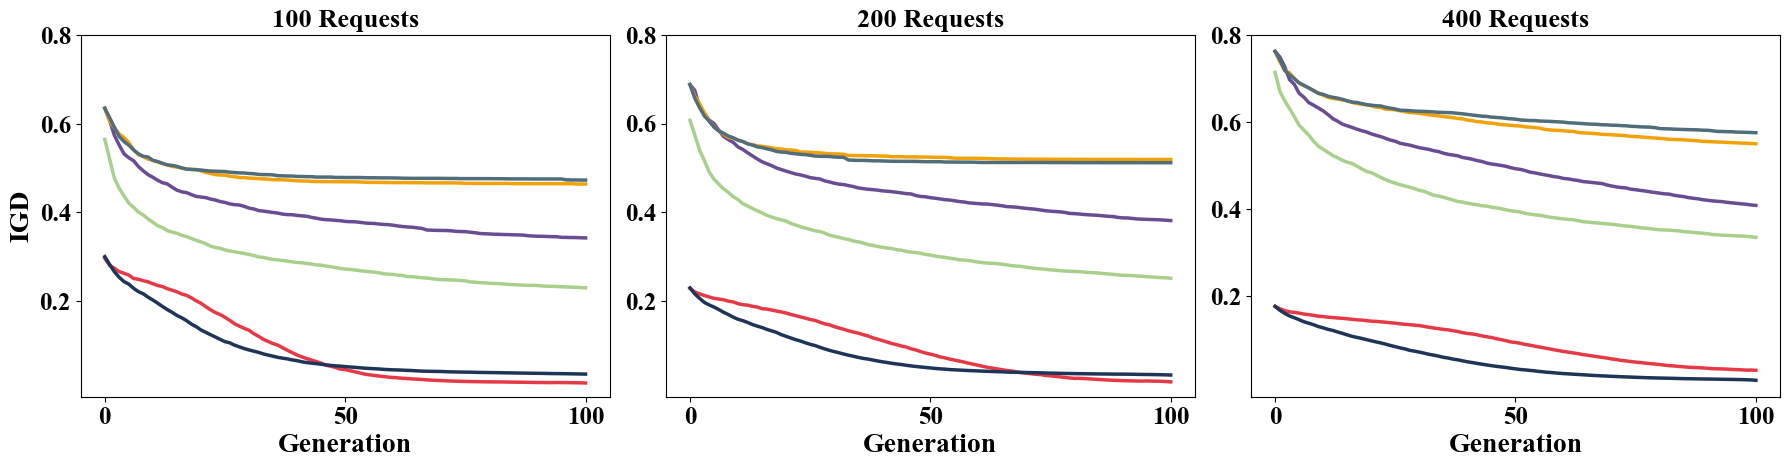

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set global font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"

# Settings
base_path = "F:/setup files/downloads/ResultLastly/"  # Ensure base_path is defined
problem_types = [200, 400, 800]

# Define custom colors for each algorithm
algorithm_colors = {
    'PFG-EMOA': '#E63946',
    'Proposed': '#1D3557',
    'Original': '#A8D08D',
    'NSGA-II': '#6A4C93',
    'MOEA/D': '#4F6D7A',
    'MOEA/D+': '#F1A208'
}

# Create a single figure with 3 subplots in one row
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5.2))
plt.subplots_adjust(top=0.85)  # Adjust top margin for titles

# Legend style
legend_font = {"family": "Times New Roman", "size": 18, "weight": "bold"}

# We'll collect legend handles and labels from all subplots
all_handles = []
all_labels = []

for idx, (ax, prob_type) in enumerate(zip(axes, problem_types)):
    csv_filename = os.path.join(base_path, f"Avg_IGD_Trends_Type_{prob_type//100}.csv")
    
    # Check if CSV exists
    if not os.path.exists(csv_filename):
        print(f"CSV file {csv_filename} not found. Skipping.")
        continue

    # Read CSV file
    df_avg_igd = pd.read_csv(csv_filename, index_col='Generation')

    # Plot convergence for each algorithm on the current subplot
    for algorithm in ['PFG-EMOA', 'Proposed','Original', 'NSGA-II', 'MOEA/D+', 'MOEA/D']:
        if algorithm not in df_avg_igd.columns:
            continue
        generations = df_avg_igd.index
        values = df_avg_igd[algorithm]
        
        # Rename algorithms for legend display
        if algorithm == 'Proposed':
            plot_label = 'PFG-2F-PM'
        elif algorithm == 'PFG-EMOA':
            plot_label = 'PFG-2F-RK'
        elif algorithm == 'Original':
            plot_label = 'PFG-MOEA'
        else:
            plot_label = algorithm
        
        # Use specified color if available
        color = algorithm_colors.get(algorithm, None)
        
        line, = ax.plot(generations, values, label=plot_label, linewidth=2.5, color=color)
        
        # Collect legend info from the first subplot iteration to avoid duplicates
        if idx == 0 and plot_label not in all_labels:
            all_handles.append(line)
            all_labels.append(plot_label)

    # Set title above each subplot as a subtitle
    ax.set_title(f'{prob_type//2} Requests', fontsize=19, fontweight='bold')

    # X and Y labels; only put y-label on the first subplot
    ax.set_xlabel('Generation', fontsize=20, fontweight='bold')
    if idx == 0:
        ax.set_ylabel('IGD', fontsize=20, fontweight='bold')

    # Set X ticks (positions)
    ax.set_xticks([0, 50, 100])
    ax.set_xticklabels([0, 50, 100], fontdict={'weight': 'bold', 'size': 18})

    # Set Y ticks (positions)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8'], fontdict={'weight': 'bold', 'size': 18})

    # Customize tick appearance: bold and larger size
    # ax.tick_params(axis='both', which='major', labelsize=12, width=2, length=6)

    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     label.set_fontweight('bold')

# Tight layout for spacing, reserving space at top for legend
plt.tight_layout(rect=[0, 0, 1, 0.92])

# Create a single legend above all subplots in one row
# fig.legend(
#     all_handles,
#     all_labels,
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1),
#     ncol=len(all_labels),  # Arrange all legend entries in one row
#     prop=legend_font
# )

output_pdf = os.path.join(base_path, "IGD_Convergence_Combined.pdf")
plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

plt.show()

